<a href="https://colab.research.google.com/github/ucheokechukwu/zero_to_mastery_courses/blob/main/Pytorch_For_Deep_Learning/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources
https://www.learnpytorch.io/02_pytorch_classification/



# 1. Preparing the Data
Make classification and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000
# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=88)

**Note**: This dataset is often what's considered a toy problem (a problem that's used to try and test things out on) in machine learning.

But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

In [2]:
display(len(X), len(y))
# first 5 samples
print(f"first 5 samples of X:\n {X[:5]}")
print(f"first 5 samples of y:\n {y[:5]}")

1000

1000

first 5 samples of X:
 [[ 0.99609062  0.02631302]
 [ 0.75257995 -0.36115968]
 [ 0.58423349  0.56453758]
 [ 0.74877263  0.32118872]
 [-0.91985235 -0.26683176]]
first 5 samples of y:
 [0 1 1 1 0]


In [3]:
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.996091,0.026313,0
1,0.752580,-0.361160,1
2,0.584233,0.564538,1
3,0.748773,0.321189,1
4,-0.919852,-0.266832,0


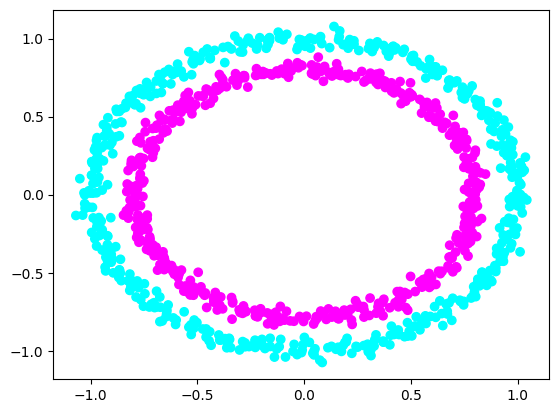

In [5]:
from matplotlib import pyplot as plt
plt.scatter(X[:,0],X[:,1],
            c=y,
            cmap='cool')

In [6]:
## turn data into Tensor

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype

torch.float32

In [7]:
# split data into training and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. building a model

1. set up device agnostic code so our code will run on GPU if it's available
2. construct a model (nn.Module):
    * subclass `nn.Module`
    * create 2 `nn.Linear()` layers
    * define a `forward()` method that outlines forward pass
    * instantiate an instance of our model class and send to target device
3. define a loss and optimizer function
4. create training and test loop

## 2.1 set up device agnostic code

In [8]:
# 2.1
import torch
from torch import nn

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2.2 construct a model

In [9]:
# 2.2
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 create 2 linear layers to handle the shape of our data
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5)
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)
    # 3 define forward method that outlines forward pass
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_1(self.layer_2(x)) # x -> layer_1 -> layer_2 -> y

# 4 instatiate our model class and send it to the target class
model_0 = CircleModel().to(device)
model_0, model_0.state_dict(), model_0.parameters

(CircleModel(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.1019, -0.7029],
                       [ 0.1639,  0.4125],
                       [-0.4129,  0.2687],
                       [ 0.5903,  0.0017],
                       [ 0.0064,  0.6926]])),
              ('layer_1.bias',
               tensor([-0.2920,  0.5177, -0.2666,  0.2443, -0.1045])),
              ('layer_2.weight',
               tensor([[-0.0310, -0.1875, -0.0399,  0.3705, -0.0568]])),
              ('layer_2.bias', tensor([-0.2012]))]),
 <bound method Module.parameters of CircleModel(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 )>)

In [10]:
next(model_0.parameters()).device

device(type='cpu')

In [11]:
# let's replicate the model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0, model_0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[ 0.3976, -0.2680],
                       [ 0.5380,  0.4619],
                       [ 0.4723, -0.3217],
                       [ 0.6212, -0.6808],
                       [ 0.5759,  0.0740]])),
              ('0.bias',
               tensor([-0.3929, -0.7011,  0.1839, -0.3348,  0.4821])),
              ('1.weight',
               tensor([[ 0.0438,  0.2556,  0.2505, -0.3361, -0.0174]])),
              ('1.bias', tensor([0.1477]))]))

In [12]:
# make some predictions
untrained_preds = model_0(X_test.to(device))
model_0.eval()
with torch.inference_mode():
    print(f"length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
    print(f"length of test samples: {len(X_test)}, shape: {(X_test.shape)}")
    print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
    print(f"\nFirst 10 test labels:\n{y_test[:10]}")

length of predictions: 200, shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.]])

First 10 test labels:
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])


## 2.3 define loss and optimizer

In [13]:
# set up loss function
# loss_fn = nn.BCELoss() # requires the input to have gon ethrough sigmoid activsation BEFORE BCELoss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation built into to the loss function
# using the combination is more numerically stable

# optimizer function
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [14]:
# calculate accuracy - out of a 100 examples, what percent does the model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

## 2.4 training and testing loop

#### 2.4.1 going from raw logits -> prediction probabilities -> prediciton lables

convert **logits** into **prediction probabilities** by passing them through an activation function (sigmoid for binary and softmax for multiclass)

we convert **prediction probabilities** to **prediction labels** by rounding them or taking the argmax.

In [15]:
# view the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    model_0.eval()
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0576],
        [0.0069],
        [0.2688],
        [0.1061],
        [0.2220]])

In [16]:
# use the sigmoid activation funciton on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5144],
        [0.5017],
        [0.5668],
        [0.5265],
        [0.5553]])

* for our prediction probability values, we need to perform a range-style rounding on them
if y_pred_probs >= 05, y=1 (class 1)
if y_pred_probs < 0.5, y=0 (class 0)

In [17]:
# round these to get the predicted labels
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [18]:
with torch.inference_mode():
    model_0.eval()
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test))).squeeze()[:5]
y_pred_labels

tensor([1., 1., 1., 1., 1.])

## 2.4.2 training and testing loop

In [19]:
torch.manual_seed(88)
torch.cuda.manual_seed(88)


epochs = 100
# put data to the devoce
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# build training and evaluation loops
for epoch in range(epochs):
    ## Training
    model_0.train()
    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
    # 2. calculate loss function (and accuracy for the fun of it)
    loss = loss_fn(y_logits, y_train) # did you notice that??
    # nn.BCEWithLogitsLoss expects y_logits
    # nn.BCELoss expects y_pred_probs i.e. torch.sigmoid(y_logits)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4. back propagation
    loss.backward()
    # 5. gradient descent/optimizer step
    optimizer.step()

    ## Testing
    model_0.eval
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch number: {epoch} | Accuracy: {acc:.3f}% | Loss: {loss:.3f} | Test loss: {test_loss:3f}, Test acc: {test_acc:2f}%")


Epoch number: 0 | Accuracy: 50.250% | Loss: 0.698 | Test loss: 0.695951, Test acc: 55.500000%
Epoch number: 10 | Accuracy: 50.250% | Loss: 0.697 | Test loss: 0.694431, Test acc: 53.500000%
Epoch number: 20 | Accuracy: 50.125% | Loss: 0.696 | Test loss: 0.693662, Test acc: 52.500000%
Epoch number: 30 | Accuracy: 50.375% | Loss: 0.696 | Test loss: 0.693246, Test acc: 52.500000%
Epoch number: 40 | Accuracy: 50.125% | Loss: 0.695 | Test loss: 0.693015, Test acc: 52.500000%
Epoch number: 50 | Accuracy: 49.750% | Loss: 0.695 | Test loss: 0.692889, Test acc: 53.000000%
Epoch number: 60 | Accuracy: 50.000% | Loss: 0.695 | Test loss: 0.692828, Test acc: 53.000000%
Epoch number: 70 | Accuracy: 50.125% | Loss: 0.694 | Test loss: 0.692806, Test acc: 52.500000%
Epoch number: 80 | Accuracy: 49.875% | Loss: 0.694 | Test loss: 0.692810, Test acc: 53.500000%
Epoch number: 90 | Accuracy: 50.125% | Loss: 0.694 | Test loss: 0.692832, Test acc: 53.000000%


### make some predictions


from the metrics, it looks like the model is not learning anything. so next step is to evaluate by making predictions and visualizing them.

to do: we're going to import a function called `plot_decision_boundary`

**madewithml.com** madewithml ops

In [20]:
import requests
from pathlib import Path
# download helper function if it's not already downloaded
if Path("helper_functions.py").is_file():
    print("helper function.py already exists, skipping download")
else:
    print("downloading helper function.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)



helper function.py already exists, skipping download


In [21]:
from helper_functions import plot_predictions, plot_decision_boundary

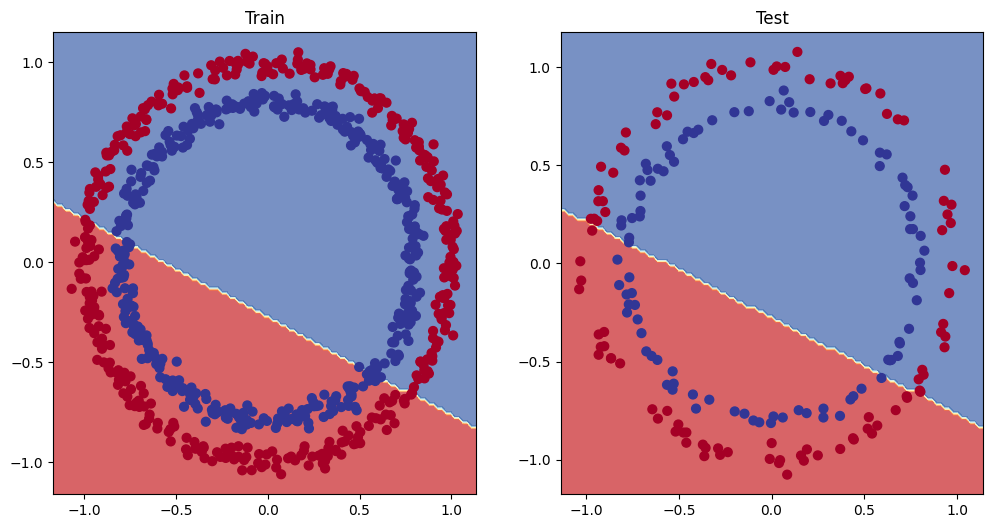

In [22]:
# plot decision
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 3. improving our model
- adding more layers
- adding more hidden units
- more epochs
- changing the activation functions
- changing the learning rate

These options are all from a model's perspective because they deal directly with the model rather than the data.

These are all hyperparameters - values that we (ML and DS) can change.

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=10)
        self.layer_2 = nn.Linear(in_features=10,
                                 out_features=10)
        self.layer_3 = nn.Linear(in_features=10,
                                 out_features=1)

    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70346, Accuracy: 49.50% | Test loss: 0.69611, Test acc: 52.00%
Epoch: 100 | Loss: 0.69304, Accuracy: 53.25% | Test loss: 0.69406, Test acc: 54.00%
Epoch: 200 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 53.00%
Epoch: 300 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69420, Test acc: 52.50%
Epoch: 400 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.00%
Epoch: 500 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.00%
Epoch: 600 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.50%
Epoch: 700 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.50%
Epoch: 800 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.50%
Epoch: 900 | Loss: 0.69303, Accuracy: 52.75% | Test loss: 0.69419, Test acc: 52.50%


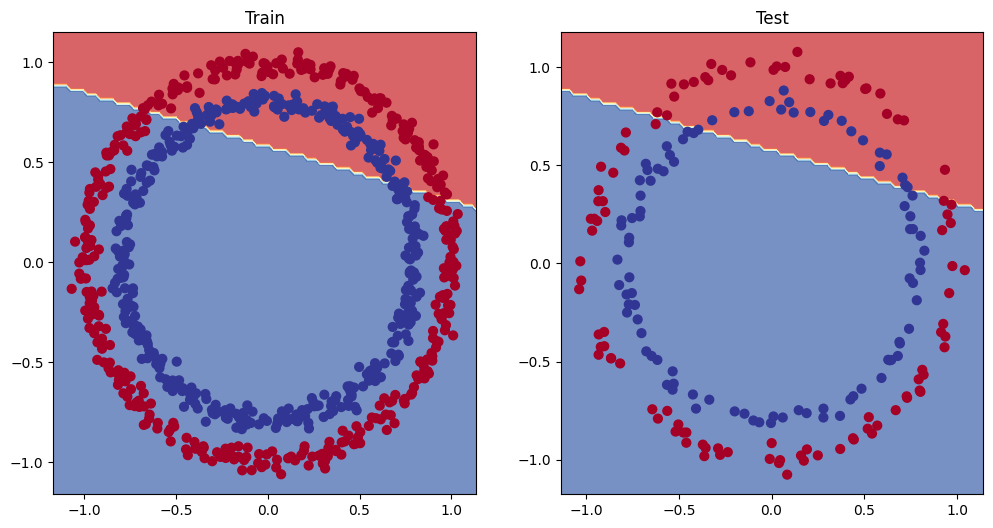

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Building a model with non-linearity

* missing function: non_linearity

In [26]:
class CircleMod(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=10)
        self.layer_2 = nn.Linear(in_features=10,
                                 out_features=10)
        self.layer_3 = nn.Linear(in_features=10,
                                 out_features=1)
        self.relu = nn.ReLU() # non linear activation function

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleMod().to(device)

In [27]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [28]:
# define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                         lr=0.1)

In [29]:
torch.manual_seed(88)
torch.cuda.manual_seed(88)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs=1000
for epoch in range(epochs):

    # training loop
    model_3.train()
    # 1. forward pass
    y_logits = model_3(X_train).squeeze()
    pred_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(pred_prob)
    # 2. loss function
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. optimizer zero gradient
    optimizer.zero_grad()
    # 4. loss backward propagation
    loss.backward()
    # 5. gradient descent
    optimizer.step() #

    ## testing loop
    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # loss function
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print results
    if epoch%100 == 0:
        print(f"Epoch: {epoch}| Accuracy {acc:2f} | Loss {loss:2f} | Test Accuracy {test_acc:2f} | Test Loss {test_loss:2f}")


Epoch: 0| Accuracy 50.500000 | Loss 0.692837 | Test Accuracy 48.000000 | Test Loss 0.693717
Epoch: 100| Accuracy 75.000000 | Loss 0.690740 | Test Accuracy 71.000000 | Test Loss 0.691975
Epoch: 200| Accuracy 58.250000 | Loss 0.688824 | Test Accuracy 58.500000 | Test Loss 0.690774
Epoch: 300| Accuracy 55.875000 | Loss 0.686135 | Test Accuracy 54.000000 | Test Loss 0.689072
Epoch: 400| Accuracy 55.000000 | Loss 0.681958 | Test Accuracy 55.000000 | Test Loss 0.686249
Epoch: 500| Accuracy 54.875000 | Loss 0.675716 | Test Accuracy 54.000000 | Test Loss 0.681548
Epoch: 600| Accuracy 55.375000 | Loss 0.666792 | Test Accuracy 55.500000 | Test Loss 0.674301
Epoch: 700| Accuracy 62.000000 | Loss 0.653822 | Test Accuracy 58.500000 | Test Loss 0.662836
Epoch: 800| Accuracy 72.500000 | Loss 0.631706 | Test Accuracy 69.000000 | Test Loss 0.643218
Epoch: 900| Accuracy 80.500000 | Loss 0.589328 | Test Accuracy 76.500000 | Test Loss 0.601923


In [30]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

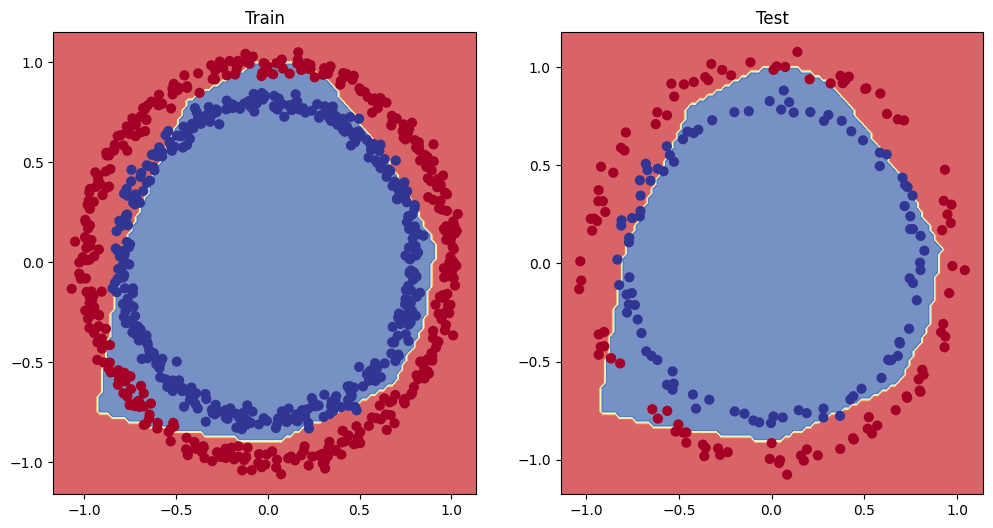

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Replicating non-linear activation functions

Neural network models: we give the models tools to discover patterns in data by their own. These tools are **linear and non-linear functions**.

In [32]:
# create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)

## relu

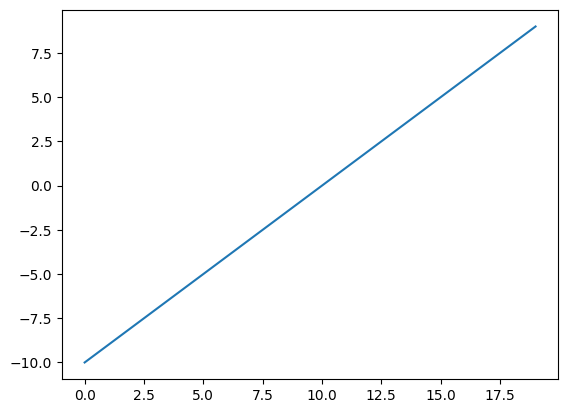

In [33]:
# visualize this data
plt.plot(A)

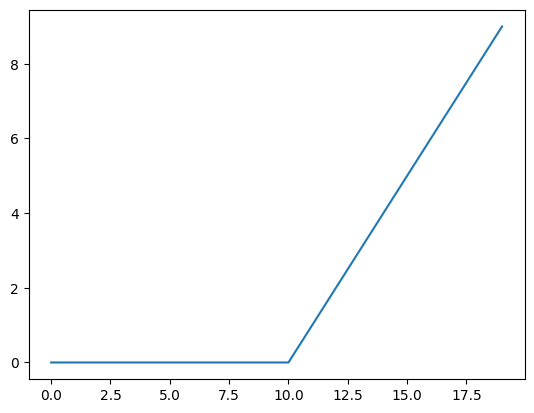

In [34]:
plt.plot(torch.relu(A))

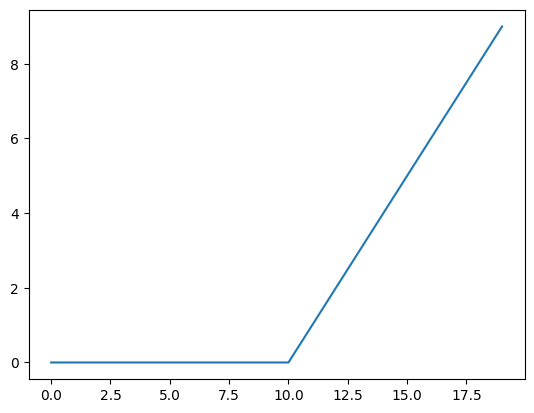

In [35]:
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors
plt.plot(relu(A))

## sigmoid

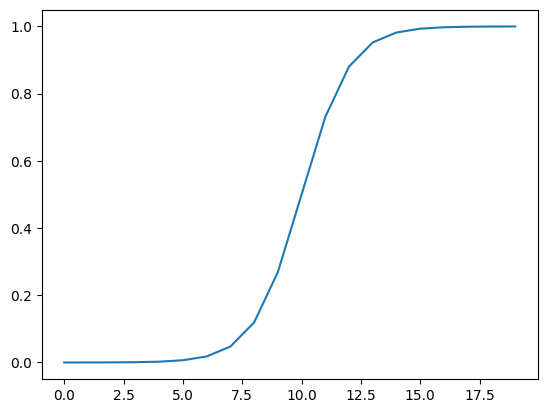

In [36]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1/(1+torch.exp(-x))

plt.plot(sigmoid(A))

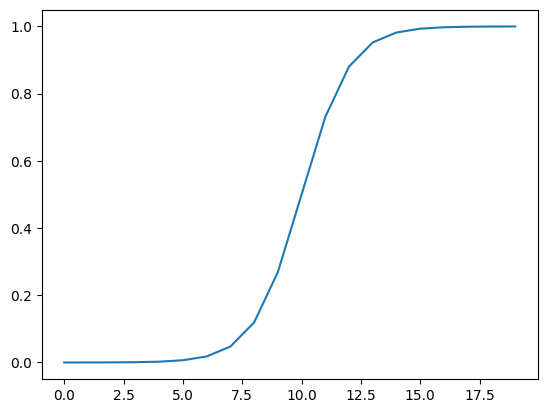

In [37]:
plt.plot(torch.sigmoid(A))

In [38]:
from sklearn.datasets import make_moons
X, y = make_moons(1000, noise=0.01)

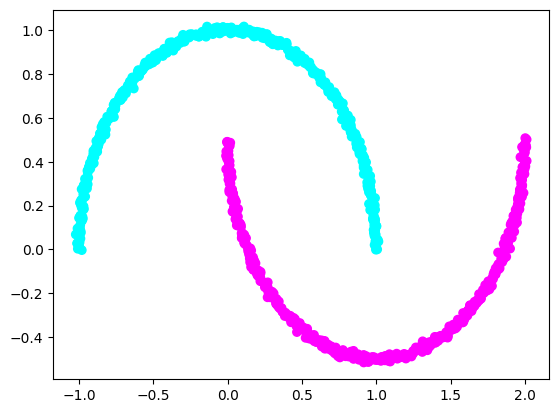

In [39]:
from matplotlib import pyplot as plt
plt.scatter(X[:,0],X[:,1],
            c=y,
            cmap='cool')

# Putting it all together with a MultiClass Classification Problem

## Data from toy dataset

In [40]:
# create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

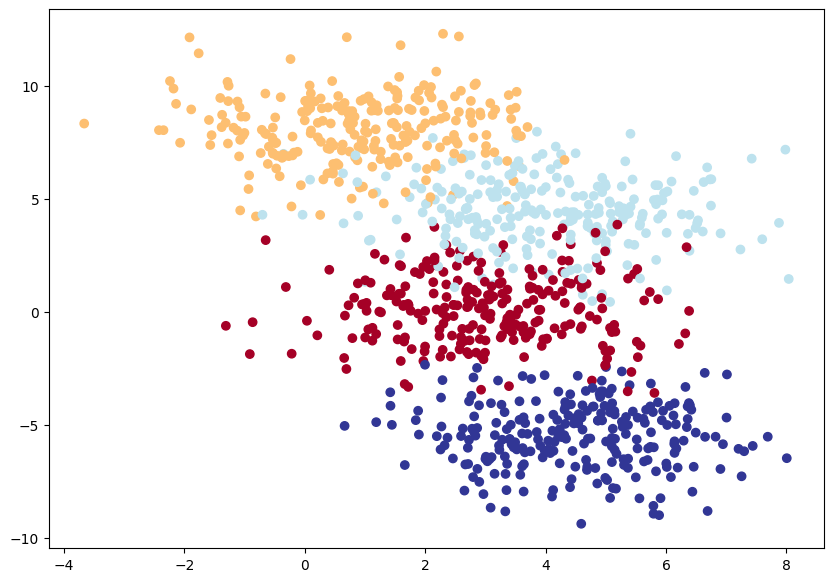

In [95]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameter for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 88

# 1. create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, # give the clusters a little shake up
                            random_state = RANDOM_SEED)



# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.long).to(device)

# 3. split into train and test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state = RANDOM_SEED)

# 4. plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],
            X_blob[:,1],
            c=y_blob,
            cmap='RdYlBu')

## buiding multiclass classification model in pytorch

In [106]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """initializes multiclass classification model.
        Args:
        input_features(int): number of input features ot the model
        output_features(int): number of output features (classes)
        hidden_units(int): number of hidden units between layers
        Returns:
        BlobModel
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_features)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

# create an instance of BlobModel
model_4 = BlobModel(input_features = NUM_FEATURES, output_features = NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## how to get multiclass labels
logits -> pred probs (torch.softmax, dim=1) -> probs (torch.argmax, dim=1)

In [46]:
# get raw outputof our model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train).to(device)
display (y_logits, len(y_logits), y_logits.shape)
y_pred_probs = torch.softmax(y_logits,dim=1)

display (y_pred_probs, len(y_pred_probs), y_pred_probs.shape)

tensor([[-0.2603,  1.3920, -1.1268,  0.1139],
        [-0.0227,  1.1523, -1.0390,  0.4961],
        [-0.0745,  1.2543, -1.1222,  0.4597],
        ...,
        [-0.0396,  1.2839, -1.1830,  0.5776],
        [-0.1145,  1.1796, -1.0338,  0.3051],
        [-0.1794,  1.2328, -1.0400,  0.1862]])

800

torch.Size([800, 4])

tensor([[0.1236, 0.6448, 0.0519, 0.1796],
        [0.1592, 0.5156, 0.0576, 0.2675],
        [0.1463, 0.5527, 0.0513, 0.2497],
        ...,
        [0.1443, 0.5421, 0.0460, 0.2675],
        [0.1523, 0.5554, 0.0607, 0.2316],
        [0.1435, 0.5890, 0.0607, 0.2068]])

800

torch.Size([800, 4])

In [48]:
torch.sum(y_pred_probs, axis=1)[:10] # all sum to 1 because they're each prediction PROBABILITIES

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [49]:
# argmax gives the class with the highest probability prediction i.e. the target class
y_pred = torch.argmax(y_pred_probs, dim=1)[:10]
y_pred

tensor([1, 1, 1, 2, 2, 1, 2, 1, 2, 2])

## training and testing loop

In [107]:
# create loss function nad optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                               lr = 0.1)

In [112]:
torch.manual_seed(RANDOM_SEED)
epochs=1000
for epoch in range(epochs):
    ## training loop
    model_4.train()
    # forward pass
    y_logit = model_4(X_blob_train)
    # y_pred_probs = torch.softmax(y_logit,dim=1)
    # y_pred = torch.argmax(y_pred_probs, dim=1)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # loss function
    loss = loss_fn(y_logit, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    # optimizer zero gradient
    optimizer.zero_grad()
    # loss backward propagation
    loss.backward()
    # gradient descent
    optimizer.step()
    ## testing loop
    model_4.eval()
    with torch.inference_mode():
        test_logit = model_4(X_blob_test)
        test_pred = torch.softmax(test_logit,dim=1).argmax(dim=1)
        # loss funciton
        test_loss = loss_fn(test_logit, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test,
                               y_pred=test_pred)

    # display output
    if epoch % 10 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:2f} | Accuracy: {acc:2f} | Test Loss : {test_loss:2f} | Test Accuracy: {test_acc:2f}")




Epoch: 0 | Loss: 0.207015 | Accuracy: 91.500000 | Test Loss : 0.198243 | Test Accuracy: 91.500000
Epoch: 10 | Loss: 0.206234 | Accuracy: 91.625000 | Test Loss : 0.197156 | Test Accuracy: 91.500000
Epoch: 20 | Loss: 0.205532 | Accuracy: 91.750000 | Test Loss : 0.195932 | Test Accuracy: 91.500000
Epoch: 30 | Loss: 0.204955 | Accuracy: 91.750000 | Test Loss : 0.194115 | Test Accuracy: 92.000000
Epoch: 40 | Loss: 0.204910 | Accuracy: 91.625000 | Test Loss : 0.191004 | Test Accuracy: 92.000000
Epoch: 50 | Loss: 0.208757 | Accuracy: 91.375000 | Test Loss : 0.186518 | Test Accuracy: 93.500000
Epoch: 60 | Loss: 0.233498 | Accuracy: 90.125000 | Test Loss : 0.187299 | Test Accuracy: 93.500000
Epoch: 70 | Loss: 0.226004 | Accuracy: 90.250000 | Test Loss : 0.183816 | Test Accuracy: 94.000000
Epoch: 80 | Loss: 0.206538 | Accuracy: 91.375000 | Test Loss : 0.185020 | Test Accuracy: 93.000000
Epoch: 90 | Loss: 0.203093 | Accuracy: 91.625000 | Test Loss : 0.187670 | Test Accuracy: 92.000000
Epoch: 100 

## making and evaluating predictions from the multiclass model

In [113]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# view the first 10 predictions
y_logits[:10]

tensor([[ -5.8681,   4.3976,   3.1606,  -8.1191],
        [  3.4031,  -5.3793,  -0.4018,  -1.7918],
        [ -0.2477,   0.3537,   0.8472,  -3.6211],
        [ -1.9917,   0.6847,   5.0047, -11.0993],
        [  4.7819,  -5.7740,  -0.9966,  -0.5819],
        [  2.9536,  -3.1636,   3.3619,  -7.5482],
        [ -0.0357,  -6.6735,  -6.7067,   9.4846],
        [  1.8664,  -2.5556,   4.4514,  -9.5687],
        [ -0.4473,  -8.0901,  -8.1128,  11.7553],
        [ -0.4610,  -0.6818,   5.3835, -11.5912]])

In [114]:
# go from logits -> pred probs -> preds
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 0, 2, 2, 0, 2, 3, 2, 3, 2]),
 tensor([2, 0, 0, 2, 0, 2, 3, 2, 3, 2]))

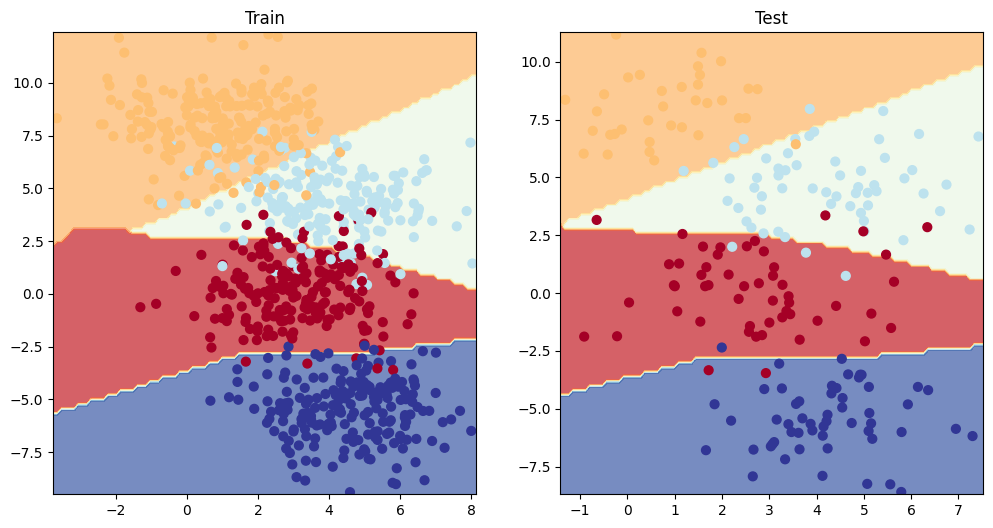

In [115]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# A few more classification metrics

Evaluating the model is just as important as training the model. Metrics are:

1. Accuracy - how many of the labels does the model get right? Good for balanced classes. Precision and Recall are good for unbalanced classes. `torchmetrics.Accuracy()`
2. Precision - `torchmetrics.Precision()`
3. Recall - `torchmetrics.Recall()`
4. F1-score - `torchmetrics.F1Score()`
5. Classification report - `sklearn.metrics.classification_report()`
6. Confusion matrix - torchmetrics.ConfusionMatrix

In [117]:
try:
    import torchmetrics
except:
    !pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 4.6 MB/s eta 0:00:00


In [121]:
from torchmetrics import Accuracy
# set up metric
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9100)